### Usando VGG en HyperFace

Entrenando Hyperface usando VGG-16 como modelo principal.

Total params: 21,644,390

In [1]:
from keras import backend as K
from keras.models import Model 
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.layers import Input, Convolution2D, MaxPooling2D, Activation, Dropout, GlobalAveragePooling2D, merge
from keras.layers.merge import concatenate
from keras.regularizers import l2
from keras import applications
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.optimizers import Adam, RMSprop
import keras.backend as kb
import keras.losses as losses
import tensorflow as tf
import os
import time
import numpy as np
import h5py
import squeeze
import hf

from keras import applications
from keras.applications.imagenet_utils import preprocess_input, decode_predictions

Using TensorFlow backend.


<!-- <img src="AlexNet-architecture.jpg"/>
<img src="HyperFace-architecture.small.png"/> -->
<img src="VGG16-architecture.png"/>

In [2]:
img_width, img_height=224, 224

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

# https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
model = applications.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [3]:
#
# Hypercaracterísticas
#

# 1er grupo de hypercaracterísticas: "conv1a" - se asume usar kernel y strides adecuados
conv1a_input = model.get_layer('block3_pool').output
#para 7x7
#conv1a = Convolution2D(128, (4,4), strides=(4,4), activation='relu', padding='valid', name='conv1a')(conv1a_input)
#para 6x6
#conv1a = Convolution2D(128, (5,5), strides=(4,4), activation='relu', padding='valid', name='conv1a')(conv1a_input)
#para 4x4
conv1a = Convolution2D(128, (6,6), strides=(6,6), activation='relu', padding='valid', name='conv1a')(conv1a_input)
print("hypercaracterísticas #1 - in:", conv1a_input.shape, 'out:', conv1a.shape)

# 2do grupo de hypercaracterísticas: "conv3a"
conv3a_input = model.get_layer('block4_pool').output
#para 7x7
#conv3a = Convolution2D(128, (2,2), strides=(2,2), activation='relu', padding='valid', name='conv3a')(conv3a_input)
#para 6x6
#conv3a = Convolution2D(128, (3,3), strides=(2,2), activation='relu', padding='valid', name='conv3a')(conv3a_input)
#para 4x4
conv3a = Convolution2D(128, (3,3), strides=(3,3), activation='relu', padding='valid', name='conv3a')(conv3a_input)
print("hypercaracterísticas #2 - in:", conv3a_input.shape, 'out:', conv3a.shape)

# 3er grupo de hypercaracterísticas: "conv5a"
conv5a_input = model.get_layer('block5_pool').output
#para 7x7
#conv5a = Convolution2D(128, (1,1), strides=(1,1), activation='relu', padding='valid', name='conv5a')(conv5a_input)
#para 6x6
#conv5a = Convolution2D(128, (2,2), strides=(1,1), activation='relu', padding='valid', name='conv5a')(conv5a_input)
#para 4x4
conv5a = Convolution2D(128, (4,4), strides=(1,1), activation='relu', padding='valid', name='conv5a')(conv5a_input)
print("hypercaracterísticas #3 - in:", conv5a_input.shape, 'out:', conv5a.shape)

# Combinación: 6x6x384
concat = concatenate([conv1a, conv3a, conv5a], axis=-1, name='concat')
print("combinación:", concat.shape)

# Reducción de dimensión: 6x6x96
conv_all = Convolution2D(96, (1, 1), strides=(1,1), activation='relu', padding='valid', name='conv_all')(concat)
print("reducción:", conv_all.shape)

# completamente conectadas
fc_full = Flatten(input_shape=conv_all.shape, name='fc_full')(conv_all)
# print(fc_full.shape)

#
# Cabezas de clasificación
#

# rostro/no rostro
fc_detecton = Dense(256, name='fc_detecton', activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.00))(fc_full)
face_nonface = Dense(2, name='face_nonface', activation='softmax', kernel_initializer='he_normal', kernel_regularizer=l2(0.00))(fc_detecton)
print("rostro/no rostro - in:", fc_detecton.shape, "out:", face_nonface.shape)

# puntos característicos
fc_landmarks = Dense(256, name='fc_landmarks', activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.00))(fc_full)
landmarks = Dense(42, name='landmarks', activation='linear', kernel_initializer='he_normal', kernel_regularizer=l2(0.00))(fc_landmarks)
print("puntos característicos - in:", fc_landmarks.shape, "out:", landmarks.shape)

# visibilidad
fc_visibility = Dense(256, name='fc_visibility', activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.00))(fc_full)
visibility = Dense(21, name='visibility', activation='sigmoid', kernel_initializer='he_normal', kernel_regularizer=l2(0.00))(fc_visibility)
print("visibilidad - in:", fc_visibility.shape, "out:", visibility.shape)

# pose
fc_pose = Dense(256, name='fc_pose', activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.00))(fc_full)
roll_pitch_yaw = Dense(3, name='roll_pitch_yaw', activation='linear', kernel_initializer='he_normal', kernel_regularizer=l2(0.00))(fc_pose)
print("pose - in:", fc_pose.shape, "out:", roll_pitch_yaw.shape)

# género
fc_gender = Dense(256, name='fc_gender', activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.00))(fc_full)
male_female = Dense(2, name='male_female', activation='softmax', kernel_initializer='he_normal', kernel_regularizer=l2(0.00))(fc_gender)
print("género - in:", fc_gender.shape, "out:", male_female.shape)

hypercaracterísticas #1 - in: (?, 28, 28, 256) out: (?, 4, 4, 128)
hypercaracterísticas #2 - in: (?, 14, 14, 512) out: (?, 4, 4, 128)
hypercaracterísticas #3 - in: (?, 7, 7, 512) out: (?, 4, 4, 128)
combinación: (?, 4, 4, 384)
reducción: (?, 4, 4, 96)
rostro/no rostro - in: (?, 256) out: (?, 2)
puntos característicos - in: (?, 256) out: (?, 42)
visibilidad - in: (?, 256) out: (?, 21)
pose - in: (?, 256) out: (?, 3)
género - in: (?, 256) out: (?, 2)


<img src="HyperFace-architecture.small.png"/>

In [4]:
hyperface = Model(inputs=model.input, outputs=[face_nonface, landmarks, visibility, roll_pitch_yaw, male_female])
hyperface.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Conv2D)            (None, 224, 224, 64)  1792        input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Conv2D)            (None, 224, 224, 64)  36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, 112, 112, 64)  0           block1_conv2[0][0]               
___________________________________________________________________________________________

<img src="HyperFace-architecture.small.png"/>

In [5]:
def custom_loss_visibility(y_true, y_pred):
    # en paper: loss = 1/N * sum((vpredi-vi)^2)
    # para entrenar:
    return (1/21) * kb.sum(kb.square(y_pred-y_true), axis=-1)
    # para debug:
    # return (1/21) * np.sum((y_pred-y_true)**2, axis=-1)

def custom_loss_pose(y_true, y_pred):
    # en paper: loss = 1/3 * sum((ppredi-pi)^2)
    # para entrenamiento:
    return (1/3) * kb.sum(kb.square(y_pred-y_true), axis=-1)
    # para debug:
    # return (1/3) * np.sum((y_pred-y_true)**2, axis=-1)

def custom_loss_landmarks(coord_true, coord_pred):    
    # en paper: loss = 1/(2N) * Sum(vi*((xpredi-ai)^2 + (ypredi-bi)^2))
    x_true_coord = coord_true[:,0:21]
    y_true_coord = coord_true[:,21:42]
    # viz_true = coord_true[:,42:63]  # produce errores en otros entornos (versión de keras?)
    x_pred_coord = coord_pred[:,0:21]
    y_pred_coord = coord_pred[:,21:42]
    # para entrenamiento:
    # return (1/(2*21)) * kb.sum(viz_true * (kb.square(x_pred_coord-x_true_coord) + K.square(y_pred_coord - y_true_coord)), axis=-1)
    return (1/(2*21)) * kb.sum((kb.square(x_pred_coord-x_true_coord) + K.square(y_pred_coord - y_true_coord)), axis=-1)
    # para debug:
    # return (1/(2*21)) * np.sum(viz_true * ((x_pred_coord-x_true_coord)**2 + (y_pred_coord - y_true_coord)**2), axis=-1)

def custom_mse_lm(y_true,y_pred):
    return kb.sign(kb.sum(kb.abs(y_true),axis=-1))*kb.sum(kb.square(tf.multiply((kb.sign(y_true)+1)*0.5, y_true-y_pred)),axis=-1)/kb.sum((kb.sign(y_true)+1)*0.5,axis=-1)

optimizer = Adam(lr=0.0001)

hyperface.compile(optimizer=optimizer,
                  loss={
                      'face_nonface': 'categorical_crossentropy',
                      'landmarks': custom_loss_landmarks,
                      'visibility': custom_loss_visibility,
                      'roll_pitch_yaw': custom_loss_pose,
                      'male_female': 'categorical_crossentropy'},
                  loss_weights={
                      'face_nonface': 1,
                      'landmarks': 1,
                      'visibility': 1,
                      'roll_pitch_yaw': 1,
                      'male_female': 1},
                 metrics=['accuracy'])

print("Modelo compilado")

Modelo compilado


In [6]:
print("Iterables para el conjunto de entrenamiento y validación")

json_dir = os.path.dirname(os.path.realpath('__file__'))  # genérico
batch_size = 5

#
# Conjunto de entrenamiento
# 

# real
trn_pos_json_file, trn_pos_count, trn_pos_batch = 'positives5k-train.json', 12116, batch_size
trn_neg_json_file, trn_neg_count, trn_neg_batch = 'negatives5k-train.json', 12116*3, batch_size*3
# prueba
#trn_pos_json_file, trn_pos_count, trn_pos_batch = 'positives.json', 2, 2
#trn_neg_json_file, trn_neg_count, trn_neg_batch = 'negatives.json', 2, 2

# iterable
train_data = hf.ImageDataGeneratorV2(samplewise_center=True, samplewise_std_normalization=True)
train_data_flow = train_data.flow_from_directory(json_dir,                                                 
                                                 trn_pos_json_file, trn_neg_json_file, 
                                                 pos_max_load_labels=trn_pos_count, neg_max_load_labels=trn_neg_count, 
                                                 pos_batch_size=trn_pos_batch, neg_batch_size=trn_neg_batch,
                                                 output_type='hyperface', target_size=(img_width, img_height))

#
# Conjunto de validación
#

# real
val_pos_json_file, val_pos_count, val_pos_batch = 'positives5k-test.json', 505, batch_size
val_neg_json_file, val_neg_count, val_neg_batch = 'negatives5k-test.json', 505*3, batch_size*3
# prueba
#val_pos_json_file, val_pos_count, val_pos_batch = 'positives.json', 2, 2
#val_neg_json_file, val_neg_count, val_neg_batch = 'negatives.json', 2, 2

# iterable
val_data = hf.ImageDataGeneratorV2(samplewise_center=True, samplewise_std_normalization=True)
val_data_flow = val_data.flow_from_directory(json_dir, 
                                             val_pos_json_file, val_neg_json_file, 
                                             pos_max_load_labels=val_pos_count, neg_max_load_labels=val_neg_count, 
                                             pos_batch_size=val_pos_batch, neg_batch_size=val_neg_batch,
                                             output_type='hyperface', target_size=(img_width, img_height))


Iterables para el conjunto de entrenamiento y validación
Found 12116 positive samples and 36348 negative samples.
Found 505 positive samples and 1515 negative samples.


In [7]:
# # checkpoint
# filepath="weights-{epoch:02d}-{loss:.2f}.hdf5"
# checkpoint = ModelCheckpoint(filepath, monitor='train_loss', verbose=1, save_best_only=False, mode='min', period=30)
# callbacks_list = [checkpoint]
# history = hyperface.fit_generator(train_data_flow, steps_per_epoch=100, epochs=300, callbacks=callbacks_list)

epochs = 25
steps_per_epoch = trn_pos_count//trn_pos_batch  # 403 para data de entrenamiento
val_steps = val_pos_count//val_pos_batch  # 16 para data de validación

model_yaml_file = 'hyperface.vgg16.model.yaml'
model_weights_file = 'hyperface.vgg16.weights.h5'
history_file = 'hyperface.vgg16.history.pkl'

print("Entrenamiento: epochs:", epochs,"steps per epoch:", steps_per_epoch, "validations steps:", val_steps)
history = hyperface.fit_generator(generator=train_data_flow,                                  
                                  steps_per_epoch=steps_per_epoch, 
                                  validation_data=val_data_flow,
                                  validation_steps=val_steps,
                                  epochs=epochs) 

print()

# guardando modelo
hyperface.save_weights(model_weights_file)
model_yaml = hyperface.to_yaml()
with open(model_yaml_file, 'w') as yaml_file:
    yaml_file.write(model_yaml)
print('Modelo y pesos escritos en disco')

# guardando history    
import pickle
with open(history_file, 'wb') as pkl_file:
    pickle.dump(history.history, pkl_file)

Entrenamiento: epochs: 25 steps per epoch: 2423 validations steps: 101
Epoch 1/25
  78/2423 [..............................] - ETA: 2536s - loss: 2.1674 - face_nonface_loss: 0.5224 - landmarks_loss: 0.6850 - visibility_loss: 0.1848 - roll_pitch_yaw_loss: 0.6053 - male_female_loss: 0.1698 - face_nonface_acc: 0.7699 - landmarks_acc: 0.0205 - visibility_acc: 0.0019 - roll_pitch_yaw_acc: 0.3295 - male_female_acc: 0.2096

/home/lmiguel/.local/lib/python3.5/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 19660800 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/lmiguel/.local/lib/python3.5/site-packages/PIL/TiffImagePlugin.py:709: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 6. 
  warnings.warn(str(msg))


 153/2423 [>.............................] - ETA: 2381s - loss: 1.5058 - face_nonface_loss: 0.4645 - landmarks_loss: 0.3980 - visibility_loss: 0.1535 - roll_pitch_yaw_loss: 0.3388 - male_female_loss: 0.1511 - face_nonface_acc: 0.7866 - landmarks_acc: 0.0203 - visibility_acc: 0.0036 - roll_pitch_yaw_acc: 0.3408 - male_female_acc: 0.1804

/home/lmiguel/.local/lib/python3.5/site-packages/PIL/TiffImagePlugin.py:709: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


 160/2423 [>.............................] - ETA: 2371s - loss: 1.4764 - face_nonface_loss: 0.4622 - landmarks_loss: 0.3847 - visibility_loss: 0.1523 - roll_pitch_yaw_loss: 0.3260 - male_female_loss: 0.1512 - face_nonface_acc: 0.7869 - landmarks_acc: 0.0197 - visibility_acc: 0.0034 - roll_pitch_yaw_acc: 0.3378 - male_female_acc: 0.1784

/home/lmiguel/.local/lib/python3.5/site-packages/PIL/TiffImagePlugin.py:709: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 0. 
  warnings.warn(str(msg))


 345/2423 [===>..........................] - ETA: 2162s - loss: 1.0713 - face_nonface_loss: 0.3959 - landmarks_loss: 0.2209 - visibility_loss: 0.1292 - roll_pitch_yaw_loss: 0.1781 - male_female_loss: 0.1472 - face_nonface_acc: 0.8191 - landmarks_acc: 0.0264 - visibility_acc: 0.0036 - roll_pitch_yaw_acc: 0.3505 - male_female_acc: 0.2577

/home/lmiguel/.local/lib/python3.5/site-packages/PIL/TiffImagePlugin.py:709: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


1068/2423 [============>.................] - ETA: 1388s - loss: 0.7106 - face_nonface_loss: 0.2734 - landmarks_loss: 0.1224 - visibility_loss: 0.0861 - roll_pitch_yaw_loss: 0.0862 - male_female_loss: 0.1425 - face_nonface_acc: 0.8871 - landmarks_acc: 0.0632 - visibility_acc: 0.0139 - roll_pitch_yaw_acc: 0.3769 - male_female_acc: 0.3819

/home/lmiguel/.local/lib/python3.5/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 80000 bytes but only got 0. Skipping tag 64640
  " Skipping tag %s" % (size, len(data), tag))
/home/lmiguel/.local/lib/python3.5/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 3368026112 bytes but only got 0. Skipping tag 7
  " Skipping tag %s" % (size, len(data), tag))
/home/lmiguel/.local/lib/python3.5/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 134479872 bytes but only got 0. Skipping tag 7
  " Skipping tag %s" % (size, len(data), tag))
/home/lmiguel/.local/lib/python3.5/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4294901760 bytes but only got 0. Skipping tag 4
  " Skipping tag %s" % (size, len(data), tag))
/home/lmiguel/.local/lib/python3.5/site-packages/PIL/TiffImagePlugin.py:69

1805/2423 [=====================>........] - ETA: 630s - loss: 0.5911 - face_nonface_loss: 0.2191 - landmarks_loss: 0.0974 - visibility_loss: 0.0703 - roll_pitch_yaw_loss: 0.0646 - male_female_loss: 0.1397 - face_nonface_acc: 0.9128 - landmarks_acc: 0.0787 - visibility_acc: 0.0269 - roll_pitch_yaw_acc: 0.3912 - male_female_acc: 0.4743

/home/lmiguel/.local/lib/python3.5/site-packages/PIL/TiffImagePlugin.py:709: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


2107/2423 [=========================>....] - ETA: 322s - loss: 0.5609 - face_nonface_loss: 0.2043 - landmarks_loss: 0.0924 - visibility_loss: 0.0661 - roll_pitch_yaw_loss: 0.0597 - male_female_loss: 0.1384 - face_nonface_acc: 0.9195 - landmarks_acc: 0.0815 - visibility_acc: 0.0297 - roll_pitch_yaw_acc: 0.3938 - male_female_acc: 0.4704

/home/lmiguel/.local/lib/python3.5/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 110428160 bytes but only got 0. Skipping tag 4
  " Skipping tag %s" % (size, len(data), tag))
/home/lmiguel/.local/lib/python3.5/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 71827456 bytes but only got 0. Skipping tag 4
  " Skipping tag %s" % (size, len(data), tag))
/home/lmiguel/.local/lib/python3.5/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 6191. Skipping tag 7
  " Skipping tag %s" % (size, len(data), tag))
/home/lmiguel/.local/lib/python3.5/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 131073 bytes but only got 6187. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/lmiguel/.local/lib/python3.5/site-packages/PIL/TiffImagePlugin.py:692: U

2423/2423 [==============================] - 2500s - loss: 0.5371 - face_nonface_loss: 0.1933 - landmarks_loss: 0.0879 - visibility_loss: 0.0629 - roll_pitch_yaw_loss: 0.0554 - male_female_loss: 0.1375 - face_nonface_acc: 0.9245 - landmarks_acc: 0.0826 - visibility_acc: 0.0277 - roll_pitch_yaw_acc: 0.3940 - male_female_acc: 0.4555 - val_loss: 0.5617 - val_face_nonface_loss: 0.2563 - val_landmarks_loss: 0.0530 - val_visibility_loss: 0.0764 - val_roll_pitch_yaw_loss: 0.0171 - val_male_female_loss: 0.1589 - val_face_nonface_acc: 0.9069 - val_landmarks_acc: 0.0743 - val_visibility_acc: 0.0287 - val_roll_pitch_yaw_acc: 0.3718 - val_male_female_acc: 0.5163
Epoch 2/25
2423/2423 [==============================] - 2489s - loss: 0.3311 - face_nonface_loss: 0.0968 - landmarks_loss: 0.0527 - visibility_loss: 0.0355 - roll_pitch_yaw_loss: 0.0229 - male_female_loss: 0.1232 - face_nonface_acc: 0.9685 - landmarks_acc: 0.0871 - visibility_acc: 0.0177 - roll_pitch_yaw_acc: 0.4113 - male_female_acc: 0.53

2423/2423 [==============================] - 2485s - loss: 0.2170 - face_nonface_loss: 0.0493 - landmarks_loss: 0.0448 - visibility_loss: 0.0255 - roll_pitch_yaw_loss: 0.0168 - male_female_loss: 0.0806 - face_nonface_acc: 0.9846 - landmarks_acc: 0.0907 - visibility_acc: 0.0405 - roll_pitch_yaw_acc: 0.4103 - male_female_acc: 0.5715 - val_loss: 0.5386 - val_face_nonface_loss: 0.2508 - val_landmarks_loss: 0.0504 - val_visibility_loss: 0.0678 - val_roll_pitch_yaw_loss: 0.0133 - val_male_female_loss: 0.1564 - val_face_nonface_acc: 0.9262 - val_landmarks_acc: 0.0624 - val_visibility_acc: 0.0139 - val_roll_pitch_yaw_acc: 0.5941 - val_male_female_acc: 0.4045
Epoch 5/25
2423/2423 [==============================] - 2485s - loss: 0.1703 - face_nonface_loss: 0.0356 - landmarks_loss: 0.0422 - visibility_loss: 0.0227 - roll_pitch_yaw_loss: 0.0151 - male_female_loss: 0.0547 - face_nonface_acc: 0.9890 - landmarks_acc: 0.0943 - visibility_acc: 0.0554 - roll_pitch_yaw_acc: 0.4147 - male_female_acc: 0.57

2423/2423 [==============================] - 2483s - loss: 0.1086 - face_nonface_loss: 0.0179 - landmarks_loss: 0.0366 - visibility_loss: 0.0184 - roll_pitch_yaw_loss: 0.0115 - male_female_loss: 0.0242 - face_nonface_acc: 0.9943 - landmarks_acc: 0.1012 - visibility_acc: 0.0426 - roll_pitch_yaw_acc: 0.4314 - male_female_acc: 0.5649 - val_loss: 0.6498 - val_face_nonface_loss: 0.3579 - val_landmarks_loss: 0.0481 - val_visibility_loss: 0.0678 - val_roll_pitch_yaw_loss: 0.0113 - val_male_female_loss: 0.1646 - val_face_nonface_acc: 0.9277 - val_landmarks_acc: 0.0772 - val_visibility_acc: 0.0287 - val_roll_pitch_yaw_acc: 0.2054 - val_male_female_acc: 0.4119
Epoch 9/25
2423/2423 [==============================] - 2483s - loss: 0.0988 - face_nonface_loss: 0.0153 - landmarks_loss: 0.0350 - visibility_loss: 0.0173 - roll_pitch_yaw_loss: 0.0108 - male_female_loss: 0.0204 - face_nonface_acc: 0.9950 - landmarks_acc: 0.1052 - visibility_acc: 0.0574 - roll_pitch_yaw_acc: 0.4328 - male_female_acc: 0.58

2423/2423 [==============================] - 2482s - loss: 0.0849 - face_nonface_loss: 0.0102 - landmarks_loss: 0.0326 - visibility_loss: 0.0156 - roll_pitch_yaw_loss: 0.0093 - male_female_loss: 0.0172 - face_nonface_acc: 0.9970 - landmarks_acc: 0.1041 - visibility_acc: 0.0355 - roll_pitch_yaw_acc: 0.4453 - male_female_acc: 0.5769 - val_loss: 0.6725 - val_face_nonface_loss: 0.3383 - val_landmarks_loss: 0.0497 - val_visibility_loss: 0.0634 - val_roll_pitch_yaw_loss: 0.0119 - val_male_female_loss: 0.2093 - val_face_nonface_acc: 0.9277 - val_landmarks_acc: 0.0792 - val_visibility_acc: 0.0198 - val_roll_pitch_yaw_acc: 0.1955 - val_male_female_acc: 0.4851
Epoch 12/25
2423/2423 [==============================] - 2482s - loss: 0.0813 - face_nonface_loss: 0.0108 - landmarks_loss: 0.0313 - visibility_loss: 0.0152 - roll_pitch_yaw_loss: 0.0088 - male_female_loss: 0.0152 - face_nonface_acc: 0.9963 - landmarks_acc: 0.1041 - visibility_acc: 0.0450 - roll_pitch_yaw_acc: 0.4467 - male_female_acc: 0.5

2423/2423 [==============================] - 2482s - loss: 0.0758 - face_nonface_loss: 0.0096 - landmarks_loss: 0.0296 - visibility_loss: 0.0141 - roll_pitch_yaw_loss: 0.0081 - male_female_loss: 0.0144 - face_nonface_acc: 0.9970 - landmarks_acc: 0.1080 - visibility_acc: 0.0304 - roll_pitch_yaw_acc: 0.4420 - male_female_acc: 0.6128 - val_loss: 0.7538 - val_face_nonface_loss: 0.3972 - val_landmarks_loss: 0.0474 - val_visibility_loss: 0.0644 - val_roll_pitch_yaw_loss: 0.0100 - val_male_female_loss: 0.2349 - val_face_nonface_acc: 0.9292 - val_landmarks_acc: 0.0708 - val_visibility_acc: 0.0257 - val_roll_pitch_yaw_acc: 0.1619 - val_male_female_acc: 0.5847
Epoch 15/25
2423/2423 [==============================] - 2481s - loss: 0.0651 - face_nonface_loss: 0.0070 - landmarks_loss: 0.0278 - visibility_loss: 0.0130 - roll_pitch_yaw_loss: 0.0072 - male_female_loss: 0.0101 - face_nonface_acc: 0.9978 - landmarks_acc: 0.1097 - visibility_acc: 0.0272 - roll_pitch_yaw_acc: 0.4451 - male_female_acc: 0.6

2423/2423 [==============================] - 2481s - loss: 0.0634 - face_nonface_loss: 0.0069 - landmarks_loss: 0.0267 - visibility_loss: 0.0123 - roll_pitch_yaw_loss: 0.0067 - male_female_loss: 0.0109 - face_nonface_acc: 0.9978 - landmarks_acc: 0.1104 - visibility_acc: 0.0298 - roll_pitch_yaw_acc: 0.4420 - male_female_acc: 0.6899 - val_loss: 0.7993 - val_face_nonface_loss: 0.4281 - val_landmarks_loss: 0.0468 - val_visibility_loss: 0.0671 - val_roll_pitch_yaw_loss: 0.0099 - val_male_female_loss: 0.2473 - val_face_nonface_acc: 0.9277 - val_landmarks_acc: 0.0851 - val_visibility_acc: 0.0356 - val_roll_pitch_yaw_acc: 0.3950 - val_male_female_acc: 0.5668
Epoch 18/25
2423/2423 [==============================] - 2481s - loss: 0.0595 - face_nonface_loss: 0.0066 - landmarks_loss: 0.0260 - visibility_loss: 0.0118 - roll_pitch_yaw_loss: 0.0065 - male_female_loss: 0.0087 - face_nonface_acc: 0.9978 - landmarks_acc: 0.1250 - visibility_acc: 0.0286 - roll_pitch_yaw_acc: 0.4421 - male_female_acc: 0.6

2423/2423 [==============================] - 2481s - loss: 0.0541 - face_nonface_loss: 0.0049 - landmarks_loss: 0.0243 - visibility_loss: 0.0107 - roll_pitch_yaw_loss: 0.0057 - male_female_loss: 0.0084 - face_nonface_acc: 0.9984 - landmarks_acc: 0.1239 - visibility_acc: 0.0228 - roll_pitch_yaw_acc: 0.4403 - male_female_acc: 0.5838 - val_loss: 0.7521 - val_face_nonface_loss: 0.4209 - val_landmarks_loss: 0.0465 - val_visibility_loss: 0.0675 - val_roll_pitch_yaw_loss: 0.0098 - val_male_female_loss: 0.2074 - val_face_nonface_acc: 0.9272 - val_landmarks_acc: 0.0728 - val_visibility_acc: 0.0173 - val_roll_pitch_yaw_acc: 0.6416 - val_male_female_acc: 0.4876
Epoch 21/25
2423/2423 [==============================] - 2494s - loss: 0.0533 - face_nonface_loss: 0.0056 - landmarks_loss: 0.0237 - visibility_loss: 0.0103 - roll_pitch_yaw_loss: 0.0055 - male_female_loss: 0.0082 - face_nonface_acc: 0.9984 - landmarks_acc: 0.1167 - visibility_acc: 0.0248 - roll_pitch_yaw_acc: 0.4515 - male_female_acc: 0.5

2423/2423 [==============================] - 2481s - loss: 0.0491 - face_nonface_loss: 0.0048 - landmarks_loss: 0.0225 - visibility_loss: 0.0095 - roll_pitch_yaw_loss: 0.0050 - male_female_loss: 0.0073 - face_nonface_acc: 0.9988 - landmarks_acc: 0.1238 - visibility_acc: 0.0602 - roll_pitch_yaw_acc: 0.4436 - male_female_acc: 0.5858 - val_loss: 0.8957 - val_face_nonface_loss: 0.5059 - val_landmarks_loss: 0.0464 - val_visibility_loss: 0.0699 - val_roll_pitch_yaw_loss: 0.0094 - val_male_female_loss: 0.2641 - val_face_nonface_acc: 0.9257 - val_landmarks_acc: 0.0738 - val_visibility_acc: 0.0223 - val_roll_pitch_yaw_acc: 0.6302 - val_male_female_acc: 0.6099
Epoch 24/25
2423/2423 [==============================] - 2495s - loss: 0.0510 - face_nonface_loss: 0.0051 - landmarks_loss: 0.0228 - visibility_loss: 0.0098 - roll_pitch_yaw_loss: 0.0052 - male_female_loss: 0.0081 - face_nonface_acc: 0.9981 - landmarks_acc: 0.1139 - visibility_acc: 0.0489 - roll_pitch_yaw_acc: 0.4450 - male_female_acc: 0.5

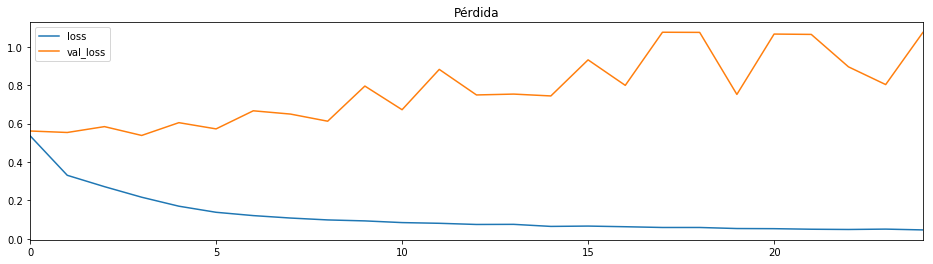

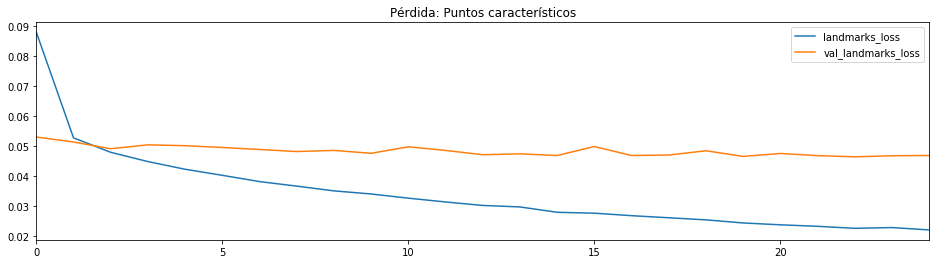

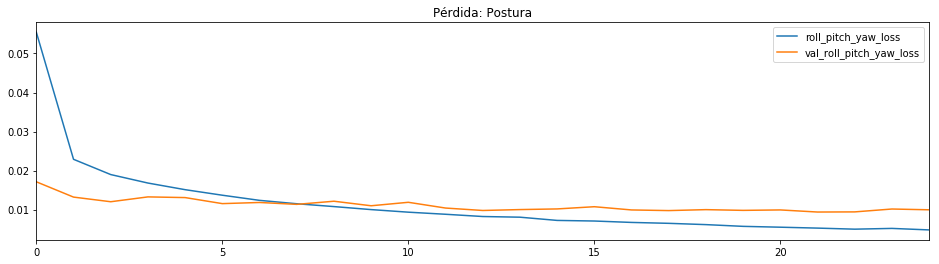

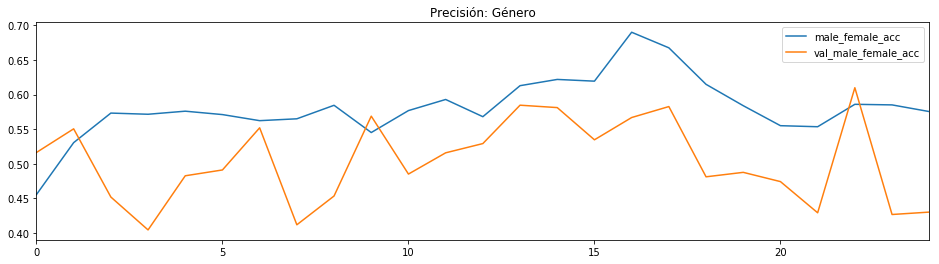

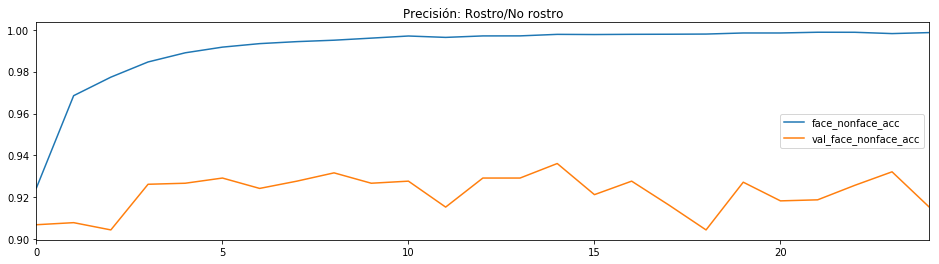

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

with open(history_file, 'rb') as pkl_file:
    history = pickle.load(pkl_file)

df = pd.DataFrame(history)
df.plot(y=['loss', 'val_loss'], figsize=(16,4), title='Pérdida')
df.plot(y=['landmarks_loss', 'val_landmarks_loss'], figsize=(16,4), title='Pérdida: Puntos característicos')
df.plot(y=['roll_pitch_yaw_loss', 'val_roll_pitch_yaw_loss'], figsize=(16,4), title='Pérdida: Postura')
df.plot(y=['male_female_acc', 'val_male_female_acc'], figsize=(16,4), title='Precisión: Género')
df.plot(y=['face_nonface_acc', 'val_face_nonface_acc'], figsize=(16,4), title='Precisión: Rostro/No rostro')
